In [1]:
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, \
                            average_precision_score,precision_score, recall_score, f1_score

import sys
sys.path.append('../scripts/')
from utils import *
from config import *
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns

from cycler import cycler
mlp.rcParams['axes.prop_cycle'] = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd',
                                                '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
mlp.rcParams['lines.linewidth'] = 2
mlp.rcParams['axes.grid'] = False
mlp.rcParams['grid.linestyle'] = '--'
mlp.rcParams['xtick.labelsize'] = 12
mlp.rcParams['ytick.labelsize'] = 12
mlp.rcParams['axes.labelsize'] = 14
mlp.rcParams['legend.fontsize'] = 12
#mlp.rcParams['axes.xmargin'] = 0.01
mlp.rcParams['font.size'] = 12
mlp.rcParams['figure.figsize'] = (5,5)

mlp.rcParams['xtick.direction'] = 'in'
mlp.rcParams['xtick.major.size'] = 3
mlp.rcParams['xtick.major.width'] = 0.5
mlp.rcParams['xtick.minor.size'] = 1.5
mlp.rcParams['xtick.minor.width'] = 0.5
mlp.rcParams['xtick.minor.visible'] = True
mlp.rcParams['xtick.top'] = True

mlp.rcParams['ytick.direction'] = 'in'
mlp.rcParams['ytick.major.size'] = 3
mlp.rcParams['ytick.major.width'] = 0.5
mlp.rcParams['ytick.minor.size'] = 1.5
mlp.rcParams['ytick.minor.width'] = 0.5
mlp.rcParams['ytick.minor.visible'] = True
mlp.rcParams['ytick.right'] = True

mlp.rcParams['font.family'] = 'serif'
mlp.rcParams['mathtext.fontset'] = 'dejavuserif'

## Load data

In [2]:
with open('../data/comb.pickle', 'rb') as handle:
    data = pickle.load(handle)

df, metadata, features, target, rows = data.values()

## Trainings

In [3]:
NUM_FOLDS = 10
NUM_REPEATS = 10

### Gradient boosting

In [4]:
train = df.loc[rows,features+[target]].copy()
train.reset_index(drop=True, inplace=True)
train[target].replace({'Bitter': 0, 'Sweet': 1}, inplace=True)
custom_cv = create_folds(train=train, features=features, target=target, num_folds=NUM_FOLDS, num_repeats=NUM_REPEATS, shuffle=True, seed=SEED)

In [5]:
# PARAMS_GB['max_bin'] = 100
# train_lgb = lgb.Dataset(train[features], train[target], feature_name=features, free_raw_data=False)
# callbacks = [lgb.log_evaluation(period=1, show_stdv=True),
#              lgb.early_stopping(stopping_rounds=PARAMS_GB['early_stopping_round'], first_metric_only=False, verbose=True)]
# cv_results = lgb.cv(params=PARAMS_GB,
#                     train_set=train_lgb,
#                     folds=custom_cv,
#                     metrics=PARAMS_GB['metric'],
#                     num_boost_round=PARAMS_GB['num_iterations'],
#                     stratified=False,
#                     callbacks=callbacks,
#                     eval_train_metric=True,
#                     return_cvbooster=True)
# best_iteration = cv_results['cvbooster'].best_iteration

# d = {'boosters': cv_results['cvbooster'].boosters, 'best_iteration': cv_results['cvbooster'].best_iteration}
# with open('../data/cv_results.pickle', 'wb') as handle:
#     pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
with open('../data/cv_results.pickle', 'rb') as handle:
    cv_results = pickle.load(handle)
best_iteration = cv_results['best_iteration']

In [7]:
train_lgb = lgb.Dataset(train[features], train[target], feature_name=features, free_raw_data=False)
PARAMS_GB_ = {i:PARAMS_GB[i] for i in PARAMS_GB if i not in ['early_stopping_round', 'num_iterations']}
gb_preds = []

for n_fold, (train_fold_idx, valid_fold_idx) in tqdm(enumerate(custom_cv), total=len(custom_cv)):
    train_fold = train.loc[train_fold_idx].copy()
    valid_fold = train.loc[valid_fold_idx].copy()
    train_fold_lgb = lgb.Dataset(train_fold[features], train_fold[target], reference=train_lgb)
    valid_fold_lgb = lgb.Dataset(valid_fold[features], valid_fold[target], reference=train_lgb)
    #model = lgb.train(PARAMS_GB_, train_fold_lgb, num_boost_round=127)
    model = cv_results['boosters'][n_fold]
    preds_fold = model.predict(valid_fold[features], num_iteration=best_iteration)
    gb_preds.append((valid_fold[target].values, preds_fold))

  0%|          | 0/100 [00:00<?, ?it/s]

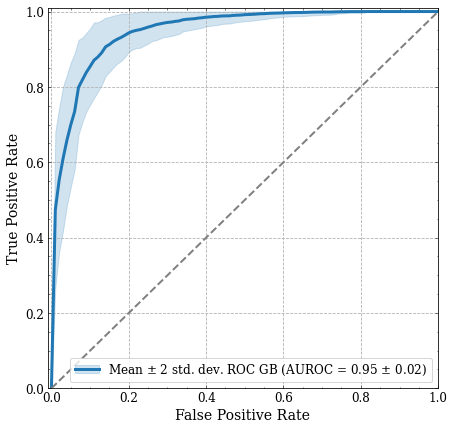

In [8]:
plot_cv_roc_curve(preds_list=[gb_preds], name_list=['GB'])

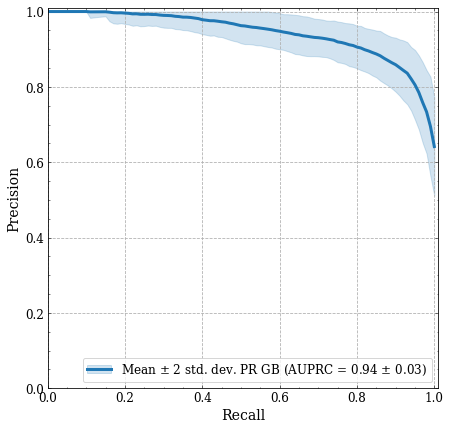

In [9]:
plot_cv_pr_curve(preds_list=[gb_preds], name_list=['GB'])

### Random forest

In [10]:
train = df.loc[rows,features+[target]].copy()
train.reset_index(drop=True, inplace=True)
train.fillna(-99999, inplace=True)
train[target].replace({'Bitter': 0, 'Sweet': 1}, inplace=True)
#train[features] = train[features].clip(train[features].quantile(0.05), train[features].quantile(0.95), axis=1)
custom_cv = create_folds(train=train, features=features, target=target, num_folds=NUM_FOLDS, num_repeats=NUM_REPEATS, shuffle=True, seed=SEED)

In [11]:
rf_preds = []

for n_fold, (train_fold_idx, valid_fold_idx) in tqdm(enumerate(custom_cv), total=len(custom_cv)):
    train_fold = train.loc[train_fold_idx].copy()
    valid_fold = train.loc[valid_fold_idx].copy()
    model = RandomForestClassifier(**PARAMS_RF)
    model.fit(train_fold[features], train_fold[target])
    preds_fold = model.predict_proba(valid_fold[features])[:,1]
    rf_preds.append((valid_fold[target].values, preds_fold))

  0%|          | 0/100 [00:00<?, ?it/s]

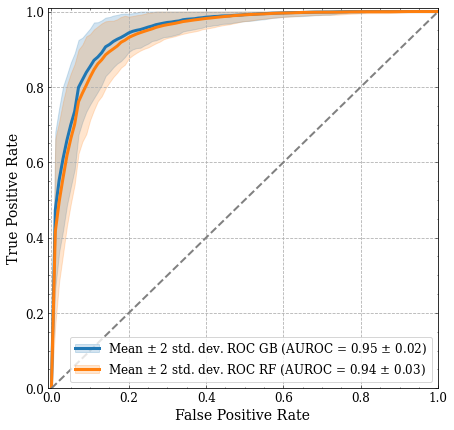

In [12]:
plot_cv_roc_curve(preds_list=[gb_preds, rf_preds], name_list=['GB', 'RF'])

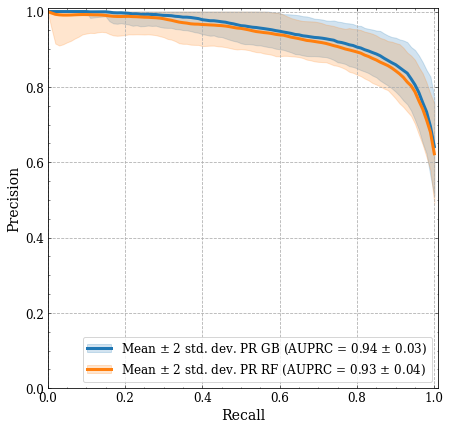

In [13]:
plot_cv_pr_curve(preds_list=[gb_preds, rf_preds], name_list=['GB', 'RF'])

### Logistic regression

In [14]:
train = df.loc[rows,features+[target]].copy()
train.reset_index(drop=True, inplace=True)
train[target].replace({'Bitter': 0, 'Sweet': 1}, inplace=True)
train[features] = train[features].clip(train[features].quantile(0.05), train[features].quantile(0.95), axis=1)
custom_cv = create_folds(train=train, features=features, target=target, num_folds=NUM_FOLDS, num_repeats=NUM_REPEATS, shuffle=True, seed=SEED)

In [15]:
lr_preds = []

for n_fold, (train_fold_idx, valid_fold_idx) in tqdm(enumerate(custom_cv), total=len(custom_cv)):
    train_fold = train.loc[train_fold_idx].copy()
    valid_fold = train.loc[valid_fold_idx].copy()
    model = make_pipeline(MinMaxScaler(),
                      SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1),
                      LogisticRegression(**PARAMS_LR))
    model.fit(train_fold[features], train_fold[target])
    preds_fold = model.predict_proba(valid_fold[features])[:,1]
    lr_preds.append((valid_fold[target].values, preds_fold))

  0%|          | 0/100 [00:00<?, ?it/s]

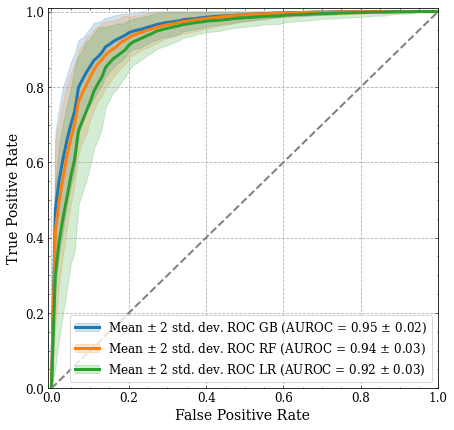

In [16]:
plot_cv_roc_curve(preds_list=[gb_preds, rf_preds, lr_preds], name_list=['GB', 'RF', 'LR'])

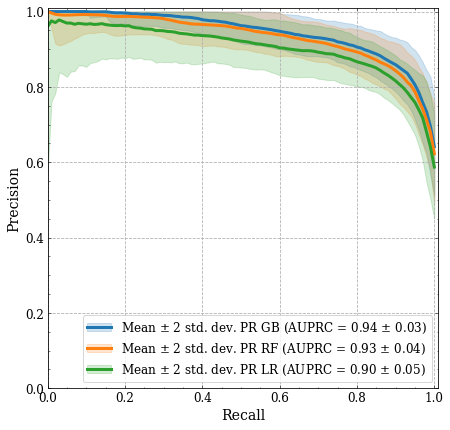

In [17]:
plot_cv_pr_curve(preds_list=[gb_preds, rf_preds, lr_preds], name_list=['GB', 'RF', 'LR'])

### MLP Classifier

In [18]:
train = df.loc[rows,features+[target]].copy()
train.reset_index(drop=True, inplace=True)
train[target].replace({'Bitter': 0, 'Sweet': 1}, inplace=True)
train[features] = train[features].clip(train[features].quantile(0.05), train[features].quantile(0.95), axis=1)
custom_cv = create_folds(train=train, features=features, target=target, num_folds=NUM_FOLDS, num_repeats=NUM_REPEATS, shuffle=True, seed=SEED)

In [19]:
nn_preds = []

for n_fold, (train_fold_idx, valid_fold_idx) in tqdm(enumerate(custom_cv), total=len(custom_cv)):
    train_fold = train.loc[train_fold_idx].copy()
    valid_fold = train.loc[valid_fold_idx].copy()
    model = make_pipeline(MinMaxScaler(),
                          SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1),
                          MLPClassifier(**PARAMS_MLP))
    model.fit(train_fold[features], train_fold[target])
    preds_fold = model.predict_proba(valid_fold[features])[:,1]
    nn_preds.append((valid_fold[target].values, preds_fold))

  0%|          | 0/100 [00:00<?, ?it/s]

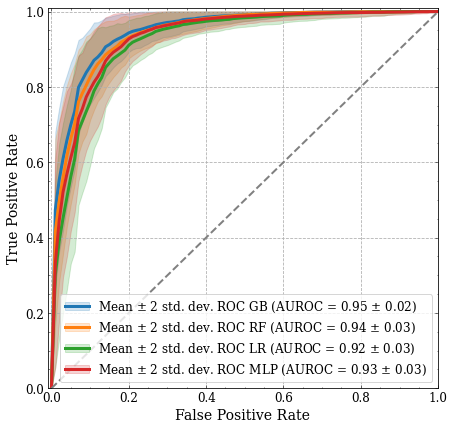

In [20]:
plot_cv_roc_curve(preds_list=[gb_preds, rf_preds, lr_preds, nn_preds], name_list=['GB', 'RF', 'LR', 'MLP'])

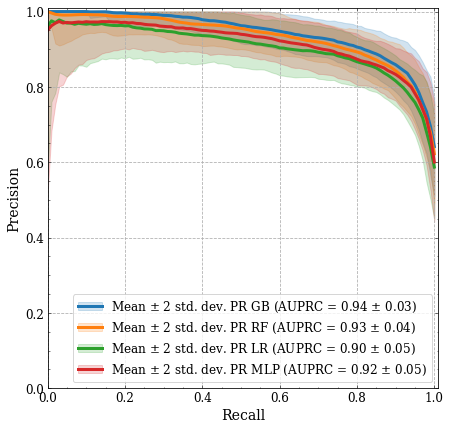

In [21]:
plot_cv_pr_curve(preds_list=[gb_preds, rf_preds, lr_preds, nn_preds], name_list=['GB', 'RF', 'LR', 'MLP'])

### k-nearest neighbors

In [22]:
train = df.loc[rows,features+[target]].copy()
train.reset_index(drop=True, inplace=True)
train[target].replace({'Bitter': 0, 'Sweet': 1}, inplace=True)
train[features] = train[features].clip(train[features].quantile(0.05), train[features].quantile(0.95), axis=1)
custom_cv = create_folds(train=train, features=features, target=target, num_folds=NUM_FOLDS, num_repeats=NUM_REPEATS, shuffle=True, seed=SEED)

In [23]:
kn_preds = []

for n_fold, (train_fold_idx, valid_fold_idx) in tqdm(enumerate(custom_cv), total=len(custom_cv)):
    train_fold = train.loc[train_fold_idx].copy()
    valid_fold = train.loc[valid_fold_idx].copy()
    model = make_pipeline(MinMaxScaler(),
                          SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1),
                          KNeighborsClassifier(**PARAMS_KNN))
    model.fit(train_fold[features], train_fold[target])
    preds_fold = model.predict_proba(valid_fold[features])[:,1]
    kn_preds.append((valid_fold[target].values, preds_fold))

  0%|          | 0/100 [00:00<?, ?it/s]

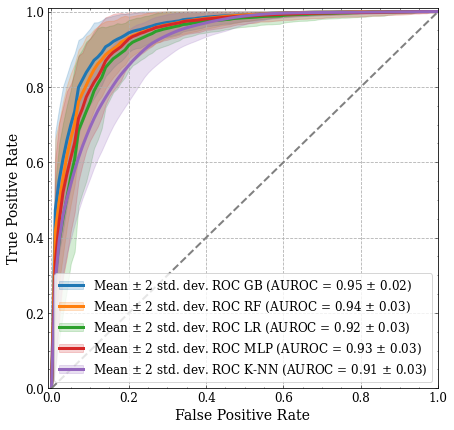

In [24]:
plot_cv_roc_curve(preds_list=[gb_preds, rf_preds, lr_preds, nn_preds, kn_preds], name_list=['GB', 'RF', 'LR', 'MLP', 'K-NN'])

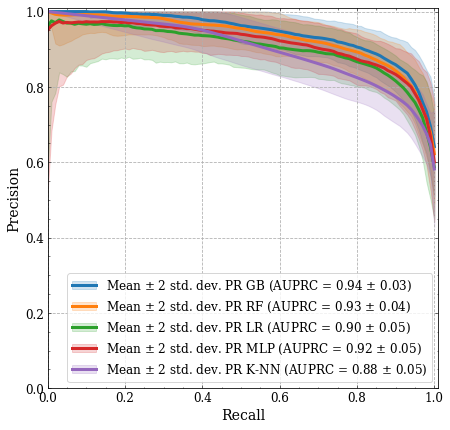

In [25]:
plot_cv_pr_curve(preds_list=[gb_preds, rf_preds, lr_preds, nn_preds, kn_preds], name_list=['GB', 'RF', 'LR', 'MLP', 'K-NN'])

## Classification reports

In [26]:
report_df = classification_report(preds_list=[gb_preds, rf_preds, lr_preds, nn_preds, kn_preds], name_list=['GB', 'RF', 'LR', 'MLP', 'K-NN'])
report_df

,avg_AUROC,avg_AUPRC,avg_Precision,avg_Recall,avg_F1_score,std_AUROC,std_AUPRC,std_Precision,std_Recall,std_F1_score
GB,0.950,0.943,0.866,0.893,0.883,0.011,0.013,0.027,0.031,0.020
RF,0.942,0.930,0.863,0.869,0.871,0.013,0.018,0.027,0.032,0.020
LR,0.924,0.905,0.838,0.877,0.860,0.015,0.026,0.030,0.030,0.020
MLP,0.934,0.917,0.848,0.868,0.862,0.014,0.023,0.031,0.045,0.023
K-NN,0.912,0.879,0.791,0.875,0.830,0.016,0.023,0.030,0.027,0.021


## Statistical analysis

In [27]:
statistical_analysis(preds_list=[gb_preds, rf_preds, lr_preds, nn_preds, kn_preds],
                     name_list=['Gradient boosting', 'Random forest', 'Logistic regression', 'Multi-layer perceptron', 'K-nearest neighbors'],
                     custom_cv=custom_cv)

,model_1,model_2,t_stat,p_val
0,Gradient boosting,Random forest,3.095,0.013
1,Gradient boosting,Logistic regression,6.828,0.000
2,Gradient boosting,Multi-layer perceptron,4.789,0.000
3,Gradient boosting,K-nearest neighbors,8.602,0.000
4,Random forest,Logistic regression,4.747,0.000
5,Random forest,Multi-layer perceptron,2.394,0.093
6,Random forest,K-nearest neighbors,6.867,0.000
7,Logistic regression,Multi-layer perceptron,-2.556,0.061
8,Logistic regression,K-nearest neighbors,2.527,0.065
9,Multi-layer perceptron,K-nearest neighbors,4.668,0.000
